In [2]:
#IMPORTS
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
#SVM KERNEL TESTING/COMPARISON

mnist = load_digits() #this is the full set with all labels
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.25, random_state=0)

kernelAccuracyDict = {"linear" : 0, "poly" : 0, "rbf" : 0, "sigmoid" : 0}

for key in kernelAccuracyDict.keys():
    kernel_test_clf = svm.SVC(probability=True,kernel=key).fit(X_train,y_train)
    y_pred = kernel_test_clf.predict(X_test)
    kernelAccuracyDict[key] = sklearn.metrics.accuracy_score(y_test, y_pred)
print(kernelAccuracyDict)
maxAccuracyKernel = max(kernelAccuracyDict, key=lambda key: kernelAccuracyDict[key])
print("Best Kernel Accuracy - ",maxAccuracyKernel,kernelAccuracyDict[maxAccuracyKernel])

#Optimize Gamma and C simultaneously
gammaList = [1.0,.01,.001,.0001]
cList = [.001,.01,1.0,10,100]
bestScore = {"gamma":0,"C":0,"accuracy":0}

for gamma in gammaList:
    for c in cList:
        test_clf = svm.SVC(kernel=maxAccuracyKernel, gamma = gamma, C = c).fit(X_train,y_train)
        y_pred = test_clf.predict(X_test)
        #print(sklearn.metrics.accuracy_score(y_test,y_pred))
        if(sklearn.metrics.accuracy_score(y_test, y_pred) > bestScore["accuracy"]):
            bestScore["gamma"] = gamma
            bestScore["C"] = c
            bestScore["accuracy"] = sklearn.metrics.accuracy_score(y_test, y_pred)

test = svm.SVC(probability=True,kernel=maxAccuracyKernel, gamma = 1 / (783 * X_train.var()), C = 1.0).fit(X_train,y_train)
y_pred = test.predict(X_test)
print("Accuracy of default C and gamma:",sklearn.metrics.accuracy_score(y_test, y_pred))

print(bestScore)


In [ ]:
#IMPORT AND VECTORIZE NEW DATASET

path = './custom_dataset/'
import os
import cv2

dir_list = os.listdir(path)

target = [0,1,2,3,4,5,6,7,8,9]

labels = pd.Series([])

for i in range(0,len(dir_list)):
    label = pd.Series([target[i % 10]])
    labels = pd.concat([labels,label])

column_names = []
[column_names.append("pixel"+str(x)) for x in range(0, 784)]

print(column_names)
i = 0
custom_dataset = pd.DataFrame(columns=column_names)
for imagePath in dir_list:
    image = cv2.imread(path+imagePath)
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    flattened = grey_image.flatten()

    custom_dataset.loc[i] = flattened
    i += 1

custom_dataset_labeled = custom_dataset.assign(label=labels.reset_index(drop=True))

train, test = train_test_split(custom_dataset_labeled, test_size=0.2, random_state=42, shuffle=True)
X_train_custom = train.loc[:,:'label']
X_test_custom = test.loc[:,:'label']
y_train_custom = train.loc[:,'label']
y_test_custom = test.loc[:,'label']

In [3]:
#MAIN SVM IMPLEMENTATION

class RBFKernel:
    def __init__(self, gamma = .001):
        self.gamma = gamma

    def __call__(self, x, y):
        return np.exp(-self.gamma * np.linalg.norm(x - y) ** 2)

class RBF_SVM_Classifier:
    def __init__(self, alpha=.001,lambda_=.001, max_iter=1000, kernel=RBFKernel(gamma=0.01)):
        self.max_iter = max_iter
        self.kernel = kernel
        self.alpha = alpha
        self.lambda_ = lambda_

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for iteration in range(self.max_iter):
            for i, Xi in enumerate(X):
                if y[i] * (np.dot(Xi, self.w) - self.b) >= 1 :
                    self.w -= self.alpha * (2 * self.lambda_ * self.w)
                else:
                    self.w -= self.alpha * (2 * self.lambda_ * self.w - np.dot(Xi, y[i]))
                    self.b -= self.alpha * y[i]
        return self.w, self.b


    def predict(self, X):
        pred = np.dot(X, self.w) - self.b
        result = [1 if val > 0 else -1 for val in pred]
        return result

class MulticlassSVM:
    def __init__(self, alpha=.001, lambda_=.001, max_iter=500, kernel=RBFKernel(gamma=0.001)):
        self.alpha = alpha
        self.lambda_ = lambda_
        self.max_iter = max_iter
        self.kernel = kernel
        self.classifiers = {}

    def fit(self, X, y):
        numbers = np.unique(y)
        for i, number in enumerate(numbers):
            binary_y = np.where(y == number, 1, -1)
            svm = RBF_SVM_Classifier(alpha=self.alpha, lambda_=self.lambda_, max_iter=self.max_iter, kernel=self.kernel)
            svm.fit(X, binary_y)
            self.classifiers[number] = svm

    def predict(self, X):
        predictions = []
        for label, classifier in self.classifiers.items():
            predictions.append(classifier.predict(X))
        predictions = np.array(predictions)
        return np.argmax(predictions, axis=0)


from sklearn.metrics import accuracy_score
mnist = load_digits() #this is the full set with all labels
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.25, random_state=0)

#Defaults
print("Defaults")
model = MulticlassSVM()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print("Train Accuracy:",accuracy_score(y_train,y_pred_train))
print("Test Accuracy:",accuracy_score(y_test,y_pred_test))

Defaults
Train Accuracy: 0.9480326651818857
Test Accuracy: 0.8733333333333333


In [ ]:
#SVM Parameter Testing

lambdaList = [.000001,.00001,.0001,.001,.1]
alphaList = [.000001,.00001,.0001,.001,.1]
gammaList = [.000001,.00001,.0001,.001,.1]

bestScore = {"lambda":0,"alpha":0,"gamma:":0,"accuracy":0}

y_axis = []
for lam in lambdaList:
    test_clf = MulticlassSVM(lambda_=lam)
    test_clf.fit(X_train,y_train)
    y_pred_comparison = test_clf.predict(X_test)
    y_axis.append(sklearn.metrics.accuracy_score(y_test,y_pred_comparison))
plt.plot(lambdaList, y_axis)
plt.title("Accuracy of Given Lambda")
plt.xlabel("Lambda")
plt.ylabel("Test Accuracy")
plt.xlim([1e-6, .1])
plt.show()

y_axis = []
for alpha in alphaList:
    test_clf = MulticlassSVM(alpha=alpha)
    test_clf.fit(X_train,y_train)
    y_pred_comparison = test_clf.predict(X_test)
    y_axis.append(sklearn.metrics.accuracy_score(y_test,y_pred_comparison))
plt.plot(lambdaList, y_axis)
plt.title("Accuracy of Given Alpha")
plt.xlabel("Alpha")
plt.ylabel("Test Accuracy")
plt.xlim([1e-6, .1])
plt.show()

y_axis = []
for gamma in gammaList:
    test_clf = MulticlassSVM(kernel=RBFKernel(gamma=gamma))
    test_clf.fit(X_train,y_train)
    y_pred_comparison = test_clf.predict(X_test)
    y_axis.append(sklearn.metrics.accuracy_score(y_test,y_pred_comparison))
plt.plot(lambdaList, y_axis)
plt.title("Accuracy of Given Gamma")
plt.xlabel("Gamma")
plt.ylabel("Test Accuracy")
plt.xlim([1e-6, .1])
plt.show()

for lam in lambdaList:
    for alpha in alphaList:
        for gamma in gammaList:
            test_clf = MulticlassSVM(lambda_ = lam, alpha = alpha,kernel=RBFKernel(gamma=gamma))
            test_clf.fit(X_train,y_train)
            y_pred_comparison = test_clf.predict(X_test)
            print("lambda:",lam,"alpha:",alpha,"gamma:",gamma,"Test Accuracy:",sklearn.metrics.accuracy_score(y_test,y_pred_comparison))
            if(sklearn.metrics.accuracy_score(y_test, y_pred_comparison) > bestScore["accuracy"]):
                bestScore["lambda"] = lam
                bestScore["alpha"] = alpha
                bestScore["accuracy"] = sklearn.metrics.accuracy_score(y_test, y_pred_comparison)

print(bestScore)

Recall: 0.8777149361022639
Precision: 0.900567856329516
F1 Score: 0.8755082409181473
Axes(0.125,0.11;0.62x0.77)


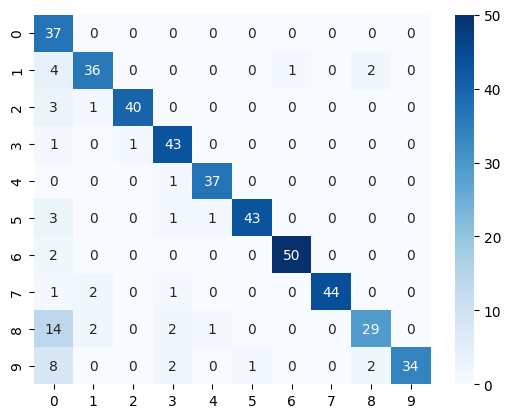

In [4]:
#Other Metrics

print("Recall:",recall_score(y_test,y_pred_test,average="macro"))
print("Precision:",precision_score(y_test,y_pred_test,average="macro"))
print("F1 Score:",f1_score(y_test,y_pred_test,average="macro"))
confusionMatrix = (confusion_matrix(y_test,y_pred_test))
print(sns.heatmap(confusionMatrix, annot=True,cmap="Blues"))